In [ ]:
import torch
import numpy as np
import pandas as pd
from joblib import load, dump
import os
import numpy as np
import cv2
from PIL import Image
import PIL
from torchvision.transforms import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from fastprogress import master_bar, progress_bar
from sklearn.model_selection import train_test_split
import time
import pickle
import argparse
import random

def mixup_data(x, y, alpha=0.4, use_cuda=True):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix_data(x, y, alpha=0.4, use_cuda=True):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [ ]:
import os
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pickle
import librosa
import librosa.display
import IPython.display
import warnings
warnings.filterwarnings(action='ignore')

from google.colab import drive
drive.mount('/content/G')

Drive already mounted at /content/G; to attempt to forcibly remount, call drive.mount("/content/G", force_remount=True).


In [ ]:
def get_abs_subdir_files(path_to_folder):

    filelist = []
    for root, dirs, files in os.walk(path_to_folder):
        for file in files:
            filelist.append(os.path.join(root,file))

    return filelist


def remove_silent_space(signal, sr=22050, threshold=0.0005):
    mask = []
    signal_abs = pd.Series(signal).apply(np.abs)
    signal_mean = signal_abs.rolling(window = int(sr/10), min_periods = 1, center = True).mean()
    for mean in signal_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return np.array(signal[mask])



def sort_audio_waves(files):
    signals = []
    for audio in files:
        signal, _ = librosa.load(audio, sr=22050)
        signals.append([audio,signal.shape[0]])
    signals_sorted = sorted(signals, key=lambda x: x[1])
    files_sorted = [item[0 ]for item in  signals_sorted]

    return files_sorted



def get_label(file):

    emotion_mappings  = {
                            "A" : 0,
                            "T" : 1,
                            "E" : 2,
                            "W" : 3,
                            "L" : 4,
                            "N" : 5,
                            "F" : 6
                        }

    return emotion_mappings[file[-6:-5]]


def get_voice_features(signal, sample_rate=22050, n_fft = 2048, hop_length = 512, n_mfcc = 13):
    """
    Creates (3, X, 230) feaures matrix from audio wave signal
    `X` varies between 50 and 700 depending on audio signal size
    """

    voice_features = []

    voice_features.append(librosa.feature.mfcc(signal, sr=sample_rate, n_fft = n_fft, hop_length=hop_length, n_mfcc=n_mfcc))
    voice_features.append(librosa.feature.melspectrogram(signal, sr=sample_rate, n_fft = n_fft, hop_length=hop_length))
    voice_features.append(librosa.feature.chroma_stft(signal, sr=sample_rate, n_fft = n_fft, hop_length=hop_length))
    # voice_features.append(librosa.feature.chroma_cqt(signal, sr=sample_rate, hop_length=hop_length))
    # voice_features.append(librosa.feature.chroma_cens(signal, sr=sample_rate, hop_length=hop_length))
    voice_features.append(librosa.feature.spectral_contrast(signal, sr=sample_rate, n_fft = n_fft, hop_length=hop_length))
    voice_features.append(librosa.feature.tonnetz(signal, sr=sample_rate, hop_length=hop_length))

    signal_harmonic, signal_percussive = librosa.effects.hpss(signal)
    melspec_harmonic = librosa.feature.melspectrogram(signal_harmonic, n_mels = 64)
    melspec_percussive = librosa.feature.melspectrogram(signal_percussive, n_mels = 64)
    hpss_hp = np.average([melspec_harmonic, melspec_percussive], axis=0)

    voice_features.append(hpss_hp)


    image_width = voice_features[0].shape[1]
    image_height = 0
    for v_feat in voice_features:
        image_height += v_feat.shape[0]


    start_index = 0
    feature = np.zeros((image_height, image_width))
    for v_feat in voice_features:
        feature[start_index: start_index + v_feat.shape[0], :] = v_feat
        start_index += v_feat.shape[0]


    feature3d = np.zeros((3, image_width, image_height))

    # feature_db = librosa.amplitude_to_db(feature)
    # feature_delta = librosa.feature.delta(feature)

    feature3d[0,:,:] = librosa.util.normalize(feature.T)
    feature3d[1,:,:] = librosa.util.normalize(feature.T)
    feature3d[2,:,:] = librosa.util.normalize(feature.T)

    return (feature3d)

In [ ]:
train_transform = T.Compose([
        T.ToPILImage(),
        T.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        T.RandomRotation(degrees=15),
        T.ColorJitter(),
        T.CenterCrop(size=224),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Note: normalize mean and std are standardized for ImageNet
transform = T.Compose([
        T.ToPILImage(),
        # T.Resize(size=256),
        # T.CenterCrop(size=224),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


def collate_batch_train(batch):

    max_signal_size = max([signal.shape[0] for (signal, label) in batch])

    signals = []
    labels = []
    for (signal, label) in batch:
        signals.append(
                        np.pad(
                                signal,
                                int(np.ceil((max_signal_size-signal.shape[0])/2)),
                                mode="reflect"
                                )[:max_signal_size-10]
                      )
        labels.append(label)

    voice_features = []
    for signal in signals:

        feat3d = get_voice_features(signal)
        feat3d = torch.from_numpy(feat3d)
        feat3d_transformered = transform(feat3d)

        voice_features.append(feat3d_transformered)

    voice_features = torch.stack(voice_features)

    labels = np.array(labels)
    labels = torch.from_numpy(labels)

    return voice_features, labels

In [ ]:
test_transform = T.Compose([
        T.ToPILImage(),
        T.Resize(size=256),
        T.CenterCrop(size=224),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


def collate_batch_test(batch):

    max_signal_size = max([signal.shape[0] for (signal, label) in batch])

    signals = []
    labels = []
    for (signal, label) in batch:
        signals.append(
                        np.pad(
                                signal,
                                int(np.ceil((max_signal_size-signal.shape[0])/2)),
                                mode="reflect"
                                )[:max_signal_size-10]
                      )
        labels.append(label)

    voice_features = []
    for signal in signals:

        feat3d = get_voice_features(signal)
        feat3d = torch.from_numpy(feat3d)
        feat3d_transformered = transform(feat3d)

        voice_features.append(feat3d_transformered)

    voice_features = torch.stack(voice_features)

    labels = np.array(labels)
    labels = torch.from_numpy(labels)

    return voice_features, labels

In [ ]:
def collate_batch(batch):

    max_signal_size = max([signal.shape[0] for (signal, label) in batch])

    signals = []
    labels = []
    for (signal, label) in batch:
        signals.append(
                        np.pad(
                                signal,
                                int(np.ceil((max_signal_size-signal.shape[0])/2)),
                                mode="reflect"
                                )[:max_signal_size-10]
                      )
        labels.append(label)

    voice_features = []
    for signal in signals:
        voice_features.append(get_voice_features(signal))

    voice_features = np.array(voice_features)
    voice_features = torch.from_numpy(voice_features.astype(np.float32))

    labels = np.array(labels)
    labels = torch.from_numpy(labels)

    return voice_features, labels



class EMODB_Dataset(Dataset):

    def __init__(self, path_to_audio_waves,  sort_data=False, sample_rate=22050):

        self.audio_waves = sort_audio_waves(get_abs_subdir_files(path_to_audio_waves))
        self.sample_rate = sample_rate

        if sort_data:
            self.audio_waves = sort_audio_waves(self.audio_waves)


    def __len__(self):
        return len(self.audio_waves)

    def __getitem__(self, idx):

        audio_file = self.audio_waves[idx]
        signal, sr = librosa.load(audio_file, sr=self.sample_rate)
        signal = remove_silent_space(signal, sr=sr)

        label = get_label(audio_file)

        return signal, label


In [ ]:
path_to_train_dataset = "/content/G/MyDrive/VED/EMO-DB-CLASSIFIED-0.2/train/"
path_to_test_dataset = "/content/G/MyDrive/VED/EMO-DB-CLASSIFIED-0.2/test/"

training_data = EMODB_Dataset(path_to_train_dataset)
test_data = EMODB_Dataset(path_to_test_dataset)

train_loader = DataLoader(training_data, batch_size=16, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True, collate_fn=collate_batch)

In [ ]:
for item in train_loader:
    print (item[0].shape)
    break

torch.Size([16, 3, 181, 230])


#VGG16 Transfer Learning

In [ ]:
# Define transfer learning model

model = torchvision.models.vgg16(pretrained=True)

for param in model.parameters():
    param.required_grad = False


classifier = nn.Sequential(
                            nn.Linear(25088, 4096),
                            nn.ReLU(True),
                            nn.Dropout(),
                            nn.Linear(4096, 4096),
                            nn.ReLU(True),
                            nn.Dropout(),
                            nn.Linear(4096, 7)
                        )

model.classifier = classifier

model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
def get_test_dataset_accuracy(test_loader, device="cuda:0"):

    n_correct = 0.
    n_total = 0.

    for inputs, targets in test_loader:

        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    return n_correct / n_total

In [ ]:
#https://www.sciencedirect.com/science/article/pii/S2405959519303455

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.000001)

In [ ]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs, cutmix_flag=True):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      if cutmix_flag:
        x_batch, y_batch_a, y_batch_b, lam =  cutmix_data(inputs, targets)
        preds = model(x_batch.cuda())
        loss = mixup_criterion(criterion,preds, y_batch_a.cuda(), y_batch_b.cuda(), lam)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      else:

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

      train_loss.append(loss.item())

        # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading

    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)


    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0

    accuracy_test = get_test_dataset_accuracy(test_loader, device="cuda:0")

    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, accuracy: {accuracy_test:.4f} Duration: {dt}')

  return train_losses, test_losses

In [ ]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=40, cutmix_flag=True)

Epoch 1/40, Train Loss: 1.8954,       Test Loss: 1.7857, accuracy: 0.2427 Duration: 0:06:21.665147
Epoch 2/40, Train Loss: 1.8120,       Test Loss: 1.5356, accuracy: 0.4563 Duration: 0:06:25.665965
Epoch 3/40, Train Loss: 1.6170,       Test Loss: 1.1523, accuracy: 0.5437 Duration: 0:06:13.485241
Epoch 4/40, Train Loss: 1.4226,       Test Loss: 0.9193, accuracy: 0.6311 Duration: 0:06:29.529258
Epoch 5/40, Train Loss: 1.3722,       Test Loss: 0.8658, accuracy: 0.6990 Duration: 0:06:26.519318
Epoch 6/40, Train Loss: 1.2608,       Test Loss: 0.8249, accuracy: 0.6893 Duration: 0:06:31.981802
Epoch 7/40, Train Loss: 1.2793,       Test Loss: 0.7469, accuracy: 0.7184 Duration: 0:06:18.418146
Epoch 8/40, Train Loss: 1.1444,       Test Loss: 0.7725, accuracy: 0.7476 Duration: 0:06:28.201605
Epoch 9/40, Train Loss: 1.0476,       Test Loss: 0.6466, accuracy: 0.7961 Duration: 0:06:22.278642
Epoch 10/40, Train Loss: 1.1180,       Test Loss: 0.6479, accuracy: 0.7767 Duration: 0:06:33.707940
Epoch 11/

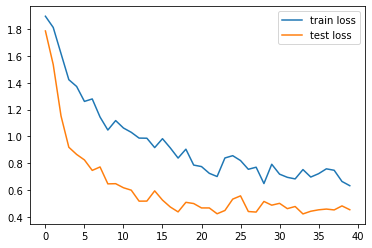

In [ ]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[11  1  0  0  0  0  1]
 [ 0 11  0  0  1  0  0]
 [ 1  1  6  0  1  0  0]
 [ 0  0  0 23  0  0  2]
 [ 0  1  0  0 12  3  0]
 [ 0  0  0  0  0 15  0]
 [ 1  0  0  4  0  0  8]]


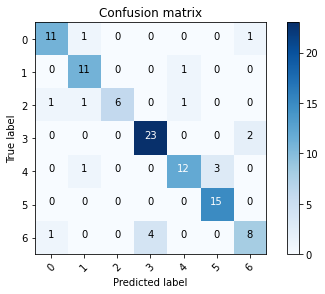

In [ ]:
# get all predictions in an array and plot confusion matrix

y_test = np.array([])
p_test = np.array([])

for inputs, targets in test_loader:
  # Move to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)

  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))
  y_test = np.concatenate((y_test, targets.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(7)))

In [ ]:
emotion_mappings  = {
                        0 :"A",
                        1 :"T",
                        2 :"E",
                        3 :"W",
                        4 :"L",
                        5 :"N",
                        6 :"F"
                    }

emotions = {
            "W" : "anger",
            "L" : "boredom",
            "E" : "disgust",
            "A" : "fear",
            "F" : "happiness",
            "T" : "sadness",
            "N" : "neutral"
            }

list_emotions=[]
for idx in range(7):
    list_emotions.append(emotions[emotion_mappings[idx]])

list_accu = np.diag(cm) / np.sum(cm, axis=0)

In [ ]:
for item in zip(list_emotions, list_accu):
    print(item)

('fear', 0.8461538461538461)
('sadness', 0.7857142857142857)
('disgust', 1.0)
('anger', 0.8518518518518519)
('boredom', 0.8571428571428571)
('neutral', 0.8333333333333334)
('happiness', 0.7272727272727273)


In [ ]:
dist = {'anger_female': (54, 13),
        'anger_male': (48, 12),
        'boredom_female': (37, 9),
        'boredom_male': (28, 7),
        'disgust_female': (28, 7),
        'disgust_male': (9, 2),
        'fear_female': (27, 6),
        'fear_male': (29, 7),
        'happiness_female': (36, 8),
        'happiness_male': (22, 5),
        'neutral_female': (32, 8),
        'neutral_male': (32, 7),
        'sadness_female': (30, 7),
        'sadness_male': (20, 5)}

In [ ]:
for inputs, targets in test_loader:

    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)

In [ ]:
inputs.shape

torch.Size([7, 3, 181, 230])

In [ ]:
window = 40
N = 4
for indx in range(1,N):
    x = torch.max(model(inputs[:,:,indx*window:(indx+1)*window,:]), 1).indices
    print(x)
print(targets)

tensor([0, 0, 0, 2, 0, 5, 6], device='cuda:0')
tensor([3, 3, 0, 4, 4, 2, 6], device='cuda:0')
tensor([1, 2, 2, 2, 1, 4, 3], device='cuda:0')
tensor([4, 2, 6, 2, 4, 4, 6], device='cuda:0')


In [ ]:
predictions

tensor([5, 2, 6, 2, 4, 4, 6], device='cuda:0')

In [ ]:
torch.max(model(inputs[:,:,0:38,:]), 1).indices

tensor([2, 2, 3, 2, 5, 1, 6], device='cuda:0')